<a href="https://colab.research.google.com/github/dKanikao26/Driver-Safety-Project/blob/main/902_rafdb_Inceptionresnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Input (100x100x3)
      ↓
EfficientNetV2L (pretrained on ImageNet, frozen)
      ↓
Flatten
      ↓
Dense(1024) → Dense(512) → Dense(256) → Dense(128) → Dense(64) → Dense(32)
      ↓
Dense(7, softmax) → Output: 7 emotion classes


In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tanishmittal/rafdb

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
! unzip /content/rafdb.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/aligned/train/train_images/train_07274_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07275_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07276_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07277_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07278_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07279_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07280_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07281_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07282_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07283_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07284_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07285_aligned.jpg  
  inflating: dataset/aligned/train/train_images/train_07286_a

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import cv2 #OpenCV: for reading, resizing, or manipulating images
import glob #	Helps you find files by pattern, like *.jpg
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras import callbacks
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

In [ ]:
df = pd.read_csv('/content/dataset/train_labels.csv')
df.head()

,image,label
0,train_00001_aligned.jpg,5
1,train_00002_aligned.jpg,5
2,train_00003_aligned.jpg,4
3,train_00004_aligned.jpg,4
4,train_00005_aligned.jpg,5


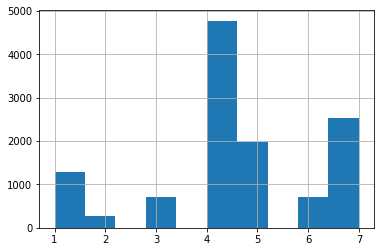

In [ ]:
df['label'].hist()

In [ ]:
input_tensor = tf.keras.Input(shape=(100, 100, 3))

In [ ]:
train_csv = pd.read_csv('/content/dataset/train_labels.csv')
test_csv = pd.read_csv('/content/dataset/test_labels.csv')
train_csv['label'] = train_csv['label'].astype(str)
test_csv['label'] = test_csv['label'].astype(str)

TensorFlow, load my images batch-by-batch from a folder + CSV, resize them to (100x100), normalize pixel values, and prepare them for training/testing

In [ ]:
datagen_train=ImageDataGenerator(rescale=1./255 ,  preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
train_generator=datagen_train.flow_from_dataframe(
dataframe=train_csv,
directory='/content/dataset/aligned/train/train_images' ,
x_col="image",
y_col="label",
batch_size=64,
color_mode='rgb',
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(100,100))

datagen_test=ImageDataGenerator(rescale=1./255 ,  preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

test_generator=datagen_test.flow_from_dataframe(
dataframe=test_csv,
directory="/content/dataset/aligned/test/test_images",
x_col="image",
y_col="label",
batch_size=64,
seed=42,
color_mode='rgb',
shuffle=True,
class_mode="categorical",
target_size=(100,100))

Found 12271 validated image filenames belonging to 7 classes.
Found 3068 validated image filenames belonging to 7 classes.


In [ ]:
img_width, img_height = 100, 100

input_tensor = tf.keras.Input(shape=(img_width, img_height, 3))
# intialize base model
base_model = tf.keras.applications.EfficientNetV2L(weights='imagenet', include_top=False, input_tensor=input_tensor)
#flatten the output since effective net is 3d feature map sow e flatten it
x = layers.Flatten()(base_model.output)
# create dense layer to understand emotion
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
# it create output whucg contain probality of each emotion
output = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(base_model.input, output)

219055592/219055592 [==============================] - 11s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(0.001)
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'binary_accuracy'])


In [ ]:
mch = callbacks.ModelCheckpoint('/fianl-model.h5' , monitor='val_loss' , mode ='min' , save_best_only=True)

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',classes = np.unique(train_generator.labels),y = train_generator.labels)
class_weights = {i : class_weights[i] for i in range(7)}


In [ ]:
model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=100, validation_data=test_generator, validation_steps=len(test_generator)  , class_weight = class_weights, callbacks =[mch])


Epoch 1/100
192/192 [==============================] - 134s 292ms/step - loss: 0.3767 - precision: 0.6251 - recall: 0.1792 - binary_accuracy: 0.8674 - val_loss: 0.5935 - val_precision: 0.5883 - val_recall: 0.4299 - val_binary_accuracy: 0.8756
Epoch 2/100
192/192 [==============================] - 49s 252ms/step - loss: 0.2717 - precision: 0.7089 - recall: 0.5150 - binary_accuracy: 0.9005 - val_loss: 0.5136 - val_precision: 0.7069 - val_recall: 0.5968 - val_binary_accuracy: 0.9071
Epoch 3/100
192/192 [==============================] - 48s 249ms/step - loss: 0.2169 - precision: 0.7610 - recall: 0.6444 - binary_accuracy: 0.9203 - val_loss: 0.2083 - val_precision: 0.7453 - val_recall: 0.6838 - val_binary_accuracy: 0.9214
Epoch 4/100
192/192 [==============================] - 45s 235ms/step - loss: 0.1878 - precision: 0.7930 - recall: 0.7087 - binary_accuracy: 0.9320 - val_loss: 0.2123 - val_precision: 0.7714 - val_recall: 0.7040 - val_binary_accuracy: 0.9279
Epoch 5/100
192/192 [==========

In [ ]:
from google.colab import files
files.upload()  # Upload `final-macro-model.zip` here


Saving final-macro-model.rar to final-macro-model.rar


In [ ]:
!unrar x /content/final-macro-model.rar /content/



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/final-macro-model.rar

Extracting  /content/final-macro-model.h5                                  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mv final-macro-model.h5 /content/drive/MyDrive/


mv: cannot stat 'final-macro-model.h5': No such file or directory


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/final-macro-model.h5')


In [ ]:
results = model.evaluate(test_generator)
print(f"\n🔍 Model Evaluation Results:\n")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")


NameError: name 'test_generator' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Class labels
labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))


Input Layer:
    - (100, 100, 3) image size (color image)

↓
EfficientNetV2L Base Model
    (pretrained on ImageNet, frozen weights)
    - Feature extractor (no top layer)

↓
Flatten Layer
    (Convert 3D feature map to 1D vector)

↓
Dense Layer (1024 units, ReLU)
↓
Dense Layer (512 units, ReLU)
↓
Dense Layer (256 units, ReLU)
↓
Dense Layer (128 units, ReLU)
↓
Dense Layer (64 units, ReLU)
↓
Dense Layer (32 units, ReLU)

↓
**New Dense Output Layer**
    - (number of micro-expression classes, softmax activation)



In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kanikadhawan11","key":"13221021b5f658029a700e55720a7ad2"}'}

In [10]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download kmirfan/micro-expressions

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/kmirfan/micro-expressions
License(s): unknown


In [11]:
! unzip /content/micro-expressions.zip

Streaming output truncated to the last 5000 lines.
  inflating: Micro_Expressions/train/happiness/happiness1041.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1042.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1043.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1044.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1045.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1046.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1047.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1048.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1049.jpg  
  inflating: Micro_Expressions/train/happiness/happiness105.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1050.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1051.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1052.jpg  
  inflating: Micro_Expressions/train/happiness/happiness1053.jpg  
  inflating:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (100, 100)  # Or (224, 224) depending on your model
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    '/content/Micro_Expressions/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/Micro_Expressions/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

# Use the second-last layer as feature extractor
x = model.layers[-2].output

# Add new output layer with correct number of micro-expression classes
new_output = Dense(train_generator.num_classes, activation='softmax', name="micro_output")(x)

# Create new model
micro_model = Model(inputs=model.input, outputs=new_output)


In [ ]:
micro_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = micro_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Start small
    verbose=1
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


191/191 ━━━━━━━━━━━━━━━━━━━━ 569s 1s/step - accuracy: 0.3737 - loss: 1.7477 - val_accuracy: 0.2307 - val_loss: 2.0433
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 408ms/step - accuracy: 0.6297 - loss: 1.0301 - val_accuracy: 0.2248 - val_loss: 2.4397
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 407ms/step - accuracy: 0.6802 - loss: 0.8708 - val_accuracy: 0.2696 - val_loss: 2.4465
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 404ms/step - accuracy: 0.7334 - loss: 0.7393 - val_accuracy: 0.4258 - val_loss: 1.6533
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 406ms/step - accuracy: 0.7868 - loss: 0.6030 - val_accuracy: 0.1800 - val_loss: 2.4051
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 407ms/step - accuracy: 0.8276 - loss: 0.5106 - val_accuracy: 0.1971 - val_loss: 2.7636
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 77s 405ms/step - accuracy: 0.8603 - loss: 0.4441 - val_accuracy: 0.2696 - val_loss: 2.7522
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 404ms/step - accuracy: 0.8883 - loss: 0.3567 - val_a

In [ ]:
micro_model.save('micro_finetuned_model.keras')#new model take keras




NameError: name 'micro_model' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mv micro_finetuned_model.keras /content/drive/MyDrive/


In [ ]:
# Evaluate the model
val_loss, val_accuracy = micro_model.evaluate(val_generator)

print(f"✅ Final Validation Accuracy: {val_accuracy * 100:.2f}%")


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.2027 - loss: 2.3582
✅ Final Validation Accuracy: 19.05%


Kaggle Micro Dataset
       ↓
Train Small Model ➔ Get experience ➔ Build full pipeline (data loading, augmentation, training)
       ↓
Large CASME II Dataset
       ↓
Load EfficientNetV2L ➔ Fine-tune slowly ➔ Get awesome accuracy!
       ↓
Final Deployment


USING EFFECIENTNETV2S ONM MICRO EXPRESSION DATASET

Input: (100, 100, 3)
↓ EfficientNetV2S (frozen)
→ Output: (4, 4, 1280)
↓ GlobalAveragePooling2D
→ Output: (1280)
↓ Dense(512)
→ Output: (512)
↓ Dropout(0.5)
→ Output: (512)
↓ Dense(5, softmax)
→ Output: (5)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


ModuleNotFoundError: No module named 'tensorflow'

Load Dataset (with Data Augmentation)

In [ ]:
img_size = (100, 100)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/Micro_Expressions/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/Micro_Expressions/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 6083 images belonging to 7 classes.
Found 372 images belonging to 7 classes.


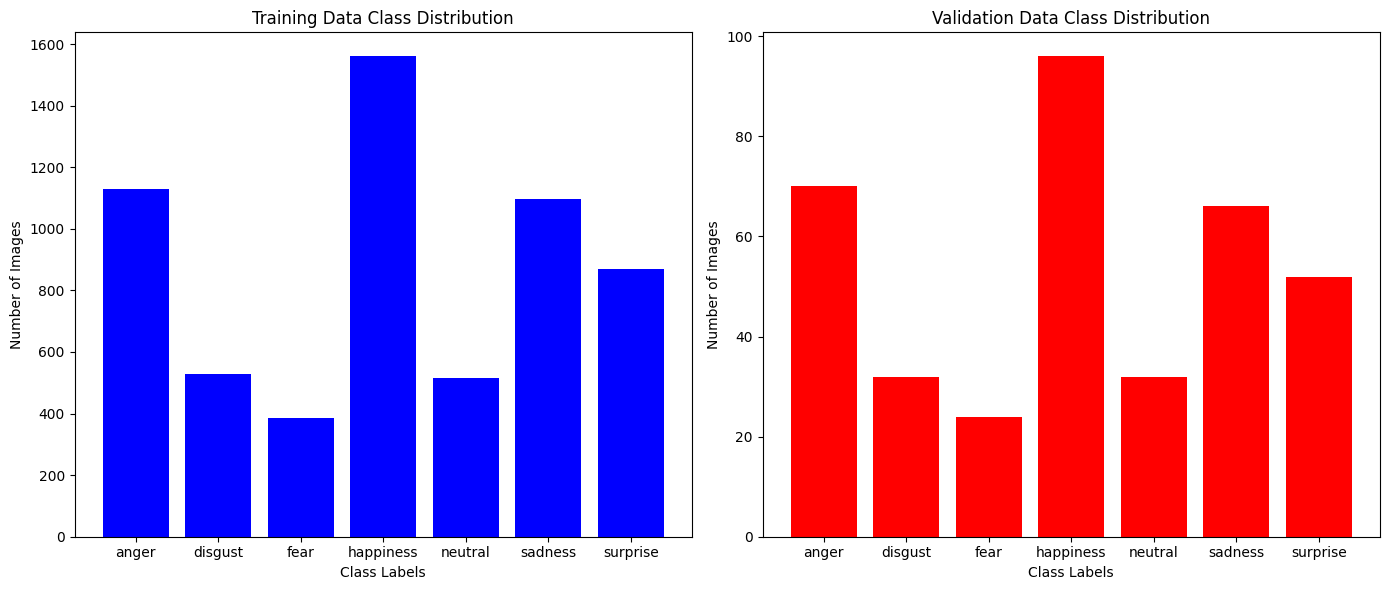

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the class labels (categories)
class_labels_train = train_generator.class_indices
class_labels_val = val_generator.class_indices

# Get the class indices and counts for training data
train_class_indices, train_class_counts = np.unique(train_generator.classes, return_counts=True)
train_class_names = [list(class_labels_train.keys())[list(class_labels_train.values()).index(idx)] for idx in train_class_indices]

# Get the class indices and counts for validation data
val_class_indices, val_class_counts = np.unique(val_generator.classes, return_counts=True)
val_class_names = [list(class_labels_val.keys())[list(class_labels_val.values()).index(idx)] for idx in val_class_indices]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training Class Distribution
axes[0].bar(train_class_names, train_class_counts, color='b')
axes[0].set_title('Training Data Class Distribution')
axes[0].set_xlabel('Class Labels')
axes[0].set_ylabel('Number of Images')

# Validation Class Distribution
axes[1].bar(val_class_names, val_class_counts, color='r')
axes[1].set_title('Validation Data Class Distribution')
axes[1].set_xlabel('Class Labels')
axes[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()


 Step 3: Build EfficientNetV2S Model

In [ ]:
base_model = EfficientNetV2S(
    weights='imagenet',
    include_top=False,
    input_shape=(100, 100, 3)
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)#Reduces the spatial dimensions (H × W) of feature maps into a single number per feature map
x = Dense(512, activation='relu')(x)# learn complexd.b with relu activation
x = Dropout(0.5)(x)#drop 50% of neuron for traning the model
output = Dense(train_generator.num_classes, activation='softmax')(x)

small_model = Model(inputs=base_model.input, outputs=output)

# Compile
small_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Together, these callbacks ensure that:

The best version of your model is saved.

Training stops once your model stops improving.

In [ ]:
checkpoint = ModelCheckpoint(
    "best_small_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
history = small_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.2381 - loss: 1.8867

191/191 ━━━━━━━━━━━━━━━━━━━━ 118s 375ms/step - accuracy: 0.2381 - loss: 1.8866 - val_accuracy: 0.2661 - val_loss: 1.8165
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2482 - loss: 1.8381

191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.2482 - loss: 1.8380 - val_accuracy: 0.2903 - val_loss: 1.8054
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.2762 - loss: 1.8054 - val_accuracy: 0.2608 - val_loss: 1.8120
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2559 - loss: 1.8196

191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - accuracy: 0.2560 - loss: 1.8196 - val_accuracy: 0.2930 - val_loss: 1.7974
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.2699 - loss: 1.8130 - val_accuracy: 0.2769 - val_loss: 1.8037
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2792 - loss: 1.8069

191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.2792 - loss: 1.8069 - val_accuracy: 0.2957 - val_loss: 1.7831
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.2677 - loss: 1.8071 - val_accuracy: 0.2634 - val_loss: 1.7999
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.2647 - loss: 1.8019 - val_accuracy: 0.2823 - val_loss: 1.7902
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.2756 - loss: 1.7967 - val_accuracy: 0.2446 - val_loss: 1.8002
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.2827 - loss: 1.8000 - val_accuracy: 0.2419 - val_loss: 1.8050
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.2794 - loss: 1.8014 - val_accuracy: 0.2876 - val_loss: 1.7929


In [ ]:
small_model.save('effecientS_micro.keras')#new model take keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!mv effecientS_micro.keras '/content/drive/MyDrive'

In [ ]:
# Evaluate the model
val_loss, val_accuracy = small_model.evaluate(val_generator)

print(f"✅ Final Validation Accuracy: {val_accuracy * 100:.2f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.3062 - loss: 1.7833
✅ Final Validation Accuracy: 30.65%


12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 965ms/step


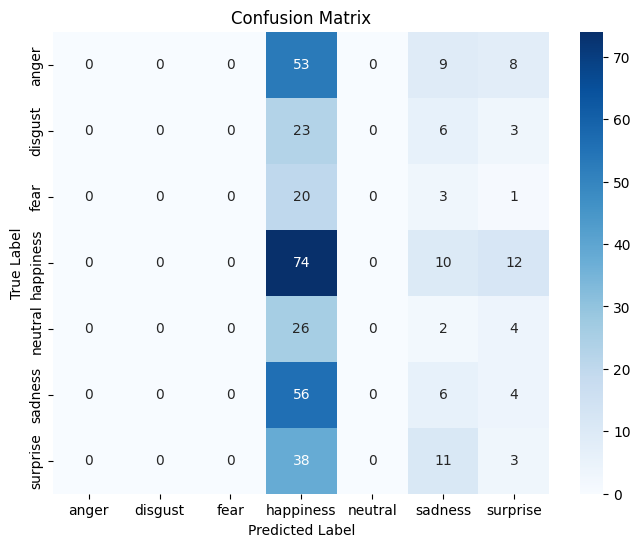

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        70
     disgust       0.00      0.00      0.00        32
        fear       0.00      0.00      0.00        24
   happiness       0.26      0.77      0.38        96
     neutral       0.00      0.00      0.00        32
     sadness       0.13      0.09      0.11        66
    surprise       0.09      0.06      0.07        52

    accuracy                           0.22       372
   macro avg       0.07      0.13      0.08       372
weighted avg       0.10      0.22      0.13       372



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Predict classes
Y_pred = small_model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes  # Ground truth

# Step 2: Get class labels
class_labels = list(val_generator.class_indices.keys())

# Step 3: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Step 5: Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Step 1: Predict
Y_pred = small_model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Step 2: Generate report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Step 3: Convert to DataFrame for easy viewing
df_report = pd.DataFrame(report).transpose()

# Step 4: Display report
print("📊 Per-Class Metrics:")
display(df_report[['precision', 'recall', 'f1-score', 'support']])


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
📊 Per-Class Metrics:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
anger,0.000000,0.000000,0.000000,70.000000
disgust,0.000000,0.000000,0.000000,32.000000
fear,0.000000,0.000000,0.000000,24.000000
happiness,0.257732,0.781250,0.387597,96.000000
neutral,0.000000,0.000000,0.000000,32.000000
sadness,0.180328,0.166667,0.173228,66.000000
surprise,0.100000,0.038462,0.055556,52.000000
accuracy,0.236559,0.236559,0.236559,0.236559
macro avg,0.076866,0.140911,0.088054,372.000000
weighted avg,0.112484,0.236559,0.138525,372.000000


some emotion like anger , disguist , fear neutral ate not gratly classified so nned some changes

In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# --- Parameters ---
img_size = (224, 224)
batch_size = 32
data_path = '/content/Micro_Expressions'

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# --- Compute Class Weights ---
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# --- Base Model ---
base_model = EfficientNetV2S(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# --- Custom Layers ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# --- Compile ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Callbacks ---
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train Initial Model ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, early_stop],
    class_weight=class_weights_dict
)

# --- Fine-tuning: Unfreeze Top Layers ---
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Continue Training ---
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, early_stop],
    class_weight=class_weights_dict
)


Found 7568 images belonging to 2 classes.
Found 1892 images belonging to 2 classes.
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5196 - loss: 0.7294

237/237 ━━━━━━━━━━━━━━━━━━━━ 1821s 8s/step - accuracy: 0.5195 - loss: 0.7293 - val_accuracy: 0.5074 - val_loss: 0.6995
Epoch 2/10
 25/237 ━━━━━━━━━━━━━━━━━━━━ 21:25 6s/step - accuracy: 0.5452 - loss: 0.6930

KeyboardInterrupt: 

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.4f}")


60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 398ms/step - accuracy: 0.6616 - loss: 0.6799
Validation Accuracy: 0.6723


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 529ms/step


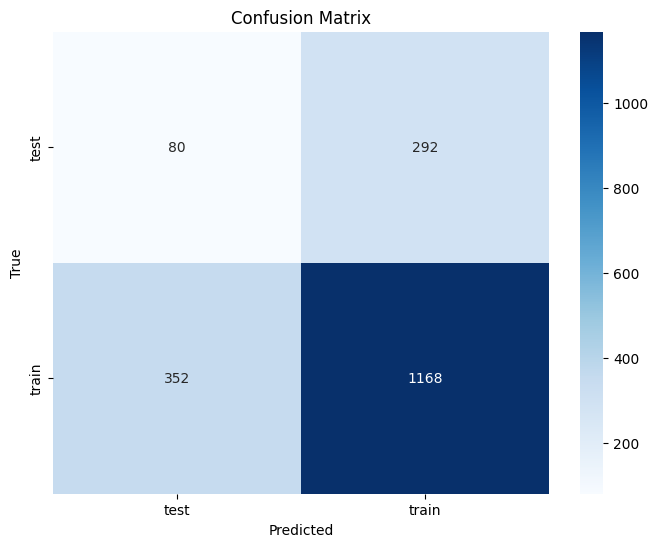

              precision    recall  f1-score   support

        test       0.19      0.22      0.20       372
       train       0.80      0.77      0.78      1520

    accuracy                           0.66      1892
   macro avg       0.49      0.49      0.49      1892
weighted avg       0.68      0.66      0.67      1892



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict labels
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))


ou have many more training samples (1520) compared to test samples (372), as seen in the support column.

Your model correctly predicted 1168 train samples, but only 80 test samples — which also suggests the model sees more "train-like" patterns and is biased toward that class.

In [ ]:
# Predicted classes
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)


60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 418ms/step


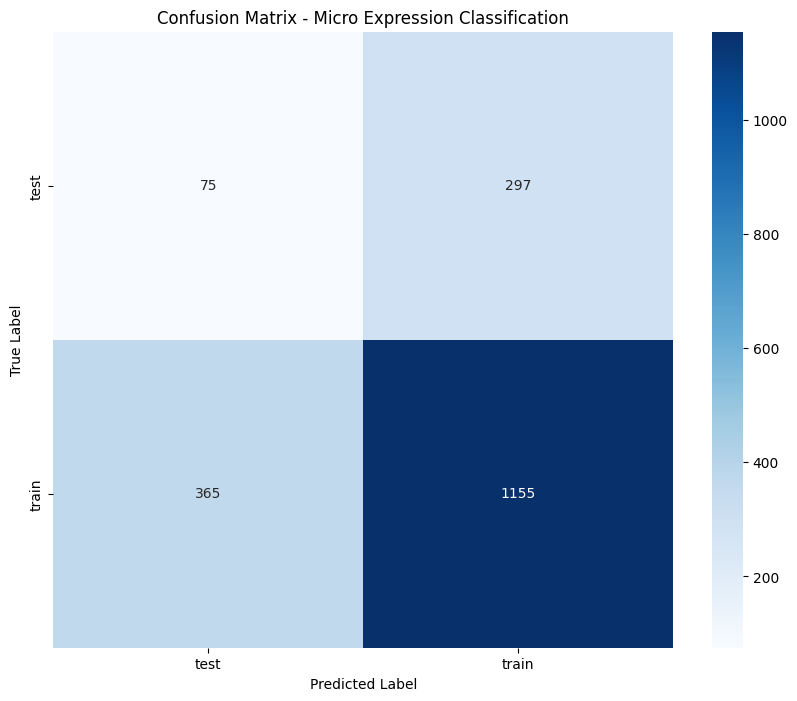

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix - Micro Expression Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


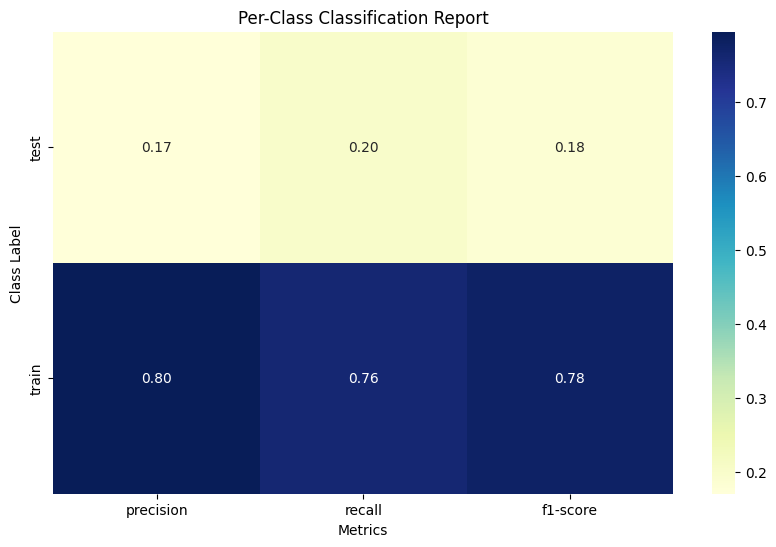

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get report as dict
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()

# Filter out accuracy/avg rows if needed
report_df = report_df.iloc[:-3, :]

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:, :3], annot=True, cmap="YlGnBu", fmt=".2f")  # Only precision, recall, f1
plt.title("Per-Class Classification Report")
plt.ylabel("Class Label")
plt.xlabel("Metrics")
plt.show()


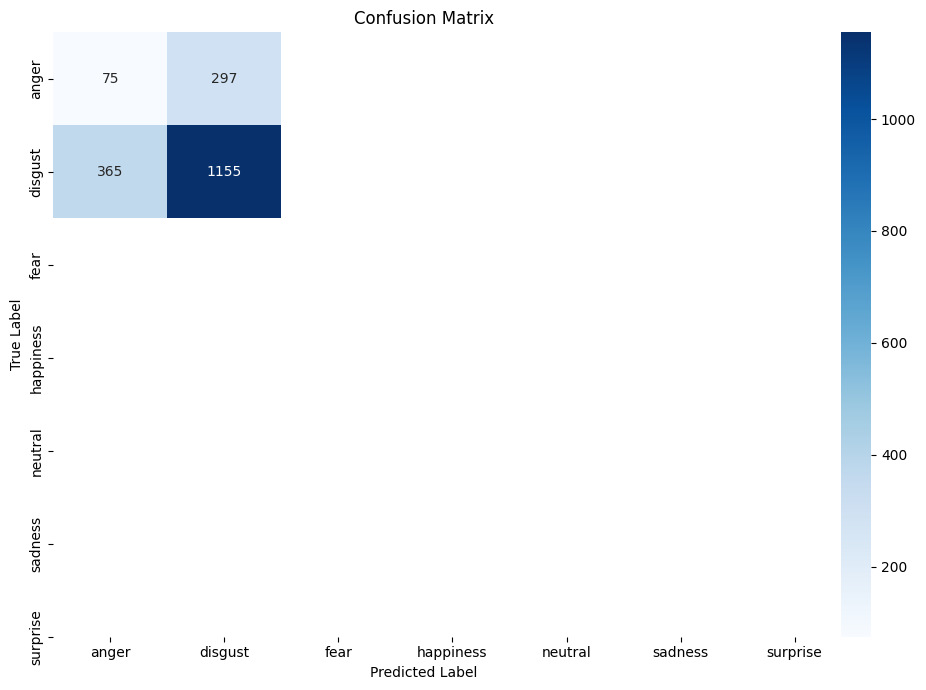

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true and y_pred are available
cm = confusion_matrix(y_true, y_pred)
class_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# Save the model in HDF5 format or SavedModel format
model.save('emotion_model.keras')  # or use .keras for Keras format


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Change the path to where you want to save in your Drive
!mv emotion_model.keras /content/drive/MyDrive/emotion_model.keras


mv: cannot stat 'emotion_model.keras': No such file or directory


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/emotion_model.h5')


| Issue                                                                     | Why it's a problem                                                                   | How to fix it                                                                                     |
| ------------------------------------------------------------------------- | ------------------------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------- |
| ❌ You trained V2L on RAFDB but are training V2S on micro data separately  | You're not *actually transferring knowledge* — these are two different architectures | ✅ Instead, train V2S on RAFDB, then fine-tune V2S on micro-expressions                            |
| ❌ Your model is misclassifying certain classes (seen in confusion matrix) | Might be due to too few samples or overlapping features                              | ✅ Try feature extraction using V2L or more balanced training                                      |
| ❌ No image preprocessing from V2 preprocessing standard                   | EfficientNet needs specific preprocessing                                            | ✅ Use `tf.keras.applications.efficientnet_v2.preprocess_input()` instead of just `rescale=1./255` |
| ❌ No learning rate schedule in fine-tuning                                | Fixed LR might be too high/low                                                       | ✅ Use a **LearningRateScheduler** or `ReduceLROnPlateau`                                          |
| ❌ Fine-tuning only top 30 layers blindly                                  | Might not unlock the best learning                                                   | ✅ Try unfreezing based on validation accuracy OR use a gradual unfreezing strategy                |


take pretraned effecientv2s model and train it on rafdb then save model use thelearning to train micro expression

PHASE 1 traning efffecientv2s on raf-db

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --- Parameters ---
img_size = (224, 224)
batch_size = 32
rafdb_path = '/content/dataset'  # update with your actual RAF-DB path

# --- Data Augmentation ---
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    rafdb_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    rafdb_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# --- Compute Class Weights ---
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

# --- Base Model ---
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# --- Compile ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Callbacks ---
checkpoint = ModelCheckpoint("effnetv2s_rafdb.h5", monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- Train ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, early_stop],
    class_weight=class_weights_dict
)

# --- Optional Fine-tune ---
for layer in base_model.layers[-30:]:
    layer.trainable = True

#Unfreezes the last 30 layers of EfficientNetV2S to fine-tune the base model.

#  Then retrains with a very small learning rate 1e-5.

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, early_stop],
    class_weight=class_weights_dict
)

# Save model
model.save("efficientnetv2s_trained_on_rafdb.h5")


Found 12272 images belonging to 1 classes.
Found 3067 images belonging to 1 classes.
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 1.0000 - loss: 0.0000e+00

384/384 ━━━━━━━━━━━━━━━━━━━━ 271s 574ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 178s 464ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 179s 467ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 178s 463ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 178s 463ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
384/384 ━━━━━━━━━━━━━━━━━━━━ 180s 469ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 1/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 292s 613ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
384/384 ━━━━━━━━━━━━

In [ ]:
model.save("efficientnetv2s_trained_on_rafdb.h5")


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
model.save('/content/drive/MyDrive/efficientnetv2s_trained_on_rafdb.h5')


NameError: name 'model' is not defined

In [4]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/efficientnetv2s_trained_on_rafdb.h5')

1. Model Setup (EfficientNetV2S + softmax)
python
Copy code


In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2S

# Load EfficientNetV2S base model
base_model = EfficientNetV2S(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze for transfer learning

# Add custom classification head
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(7, activation='softmax')(x)  # 7 classes
model = tf.keras.Model(inputs, outputs)


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_size = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% for validation
)

train_generator = datagen.flow_from_directory(
    '/content/Micro_Expressions/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # 7-class one-hot encoded
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/Micro_Expressions/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 6083 images belonging to 7 classes.
Found 1517 images belonging to 7 classes.


In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 113s 325ms/step - accuracy: 0.2293 - loss: 1.8497 - val_accuracy: 0.2782 - val_loss: 1.8017
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.2728 - loss: 1.7986 - val_accuracy: 0.2900 - val_loss: 1.7729
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 111ms/step - accuracy: 0.2818 - loss: 1.7731 - val_accuracy: 0.3006 - val_loss: 1.7591
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.3032 - loss: 1.7641 - val_accuracy: 0.3105 - val_loss: 1.7498
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.2859 - loss: 1.7534 - val_accuracy: 0.3144 - val_loss: 1.7398
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.2983 - loss: 1.7515 - val_accuracy: 0.3217 - val_loss: 1.7323
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.2998 - loss: 1.7465 - val_accuracy: 0.3316 - val_loss: 1.7241
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.3102 - loss: 

191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step - accuracy: 0.3398 - loss: 1.6702
✅ Training Accuracy: 0.35
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 87ms/step


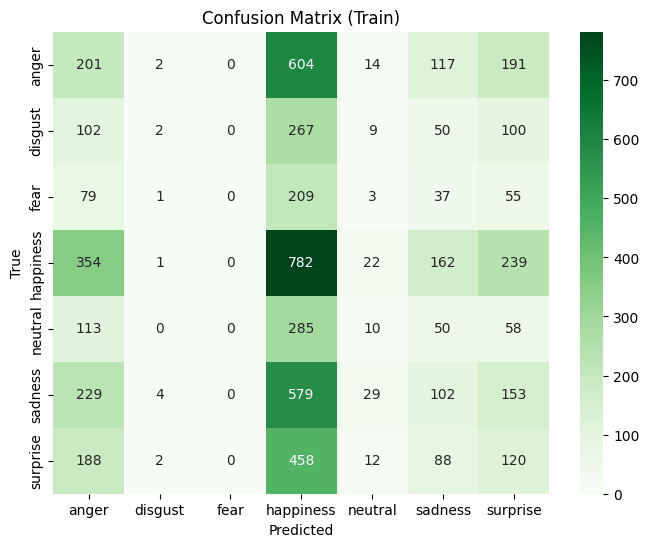


Classification Report (Train):

              precision    recall  f1-score   support

       anger       0.16      0.18      0.17      1129
     disgust       0.17      0.00      0.01       530
        fear       0.00      0.00      0.00       384
   happiness       0.25      0.50      0.33      1560
     neutral       0.10      0.02      0.03       516
     sadness       0.17      0.09      0.12      1096
    surprise       0.13      0.14      0.13       868

    accuracy                           0.20      6083
   macro avg       0.14      0.13      0.11      6083
weighted avg       0.16      0.20      0.16      6083



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Predict on training set
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
train_loss, train_acc = model.evaluate(train_generator)
print(f"✅ Training Accuracy: {train_acc:.2f}")

# Get predictions for training set
train_pred_probs = model.predict(train_generator)
train_pred = np.argmax(train_pred_probs, axis=1)
train_true = train_generator.classes
train_labels = list(train_generator.class_indices.keys())

# Confusion matrix
cm_train = confusion_matrix(train_true, train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=train_labels, yticklabels=train_labels, cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Train)')
plt.show()

# Classification report
print("\nClassification Report (Train):\n")
print(classification_report(train_true, train_pred, target_names=train_labels))


In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Save full model
model.save('/content/drive/MyDrive/efficientv2_micro_expression_model.h5')


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/efficientv2_micro_expression_model.h5')


In [27]:
import os
import shutil

def restructure_to_binary(root_path):
    neutral_dir = os.path.join(root_path, 'neutral')
    non_neutral_dir = os.path.join(root_path, 'non-neutral')

    os.makedirs(non_neutral_dir, exist_ok=True)

    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path, folder)

        if not os.path.isdir(folder_path) or folder in ['neutral', 'non-neutral']:
            continue

        if folder.lower() != 'neutral':
            for file in os.listdir(folder_path):
                shutil.move(os.path.join(folder_path, file), os.path.join(non_neutral_dir, file))
            os.rmdir(folder_path)  # delete the old folder
    print(f"Restructured {root_path}")

restructure_to_binary('/content/Micro_Expressions/train')
restructure_to_binary('/content/Micro_Expressions/test')


Restructured /content/Micro_Expressions/train
Restructured /content/Micro_Expressions/test


Load and Preprocess the Binary Dataset

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/Micro_Expressions/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/Micro_Expressions/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/Micro_Expressions/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 6081 images belonging to 2 classes.
Found 1519 images belonging to 2 classes.
Found 1860 images belonging to 2 classes.


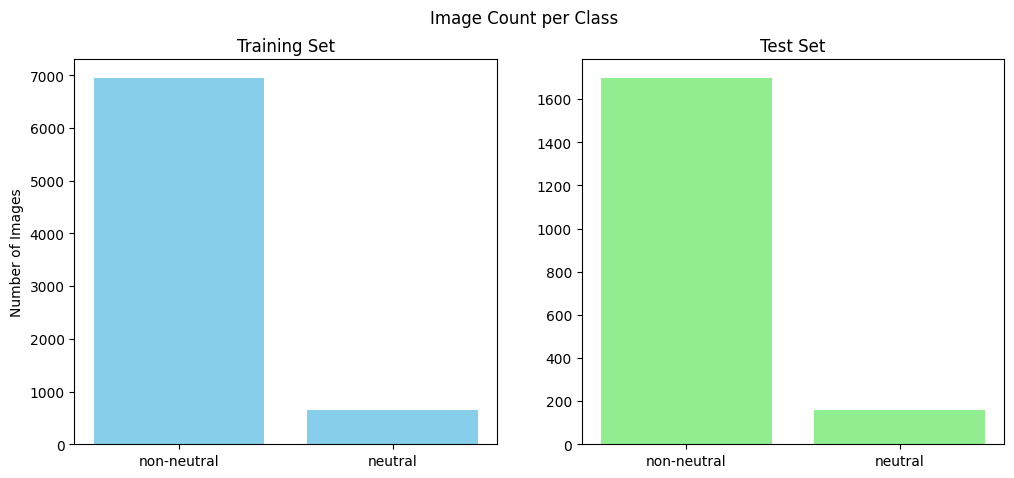

In [29]:
import os
import matplotlib.pyplot as plt

# Paths to class folders
train_path = '/content/Micro_Expressions/train'
test_path = '/content/Micro_Expressions/test'

def count_images_per_class(path):
    class_counts = {}
    for class_name in os.listdir(path):
        class_folder = os.path.join(path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

# Get image counts
train_counts = count_images_per_class(train_path)
test_counts = count_images_per_class(test_path)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Training
axs[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
axs[0].set_title("Training Set")
axs[0].set_ylabel("Number of Images")

# Test
axs[1].bar(test_counts.keys(), test_counts.values(), color='lightgreen')
axs[1].set_title("Test Set")

plt.suptitle("Image Count per Class")
plt.show()


neutral → 1

others (anger, fear, etc.) → 0

In [30]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import models, layers

base_model = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)

base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [32]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.9167 - loss: 0.2672 - val_accuracy: 0.9157 - val_loss: 0.2706
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.9163 - loss: 0.2699 - val_accuracy: 0.9157 - val_loss: 0.2703
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.9114 - loss: 0.2820 - val_accuracy: 0.9157 - val_loss: 0.2700
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - accuracy: 0.9085 - loss: 0.2802 - val_accuracy: 0.9157 - val_loss: 0.2686
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.9153 - loss: 0.2709 - val_accuracy: 0.9157 - val_loss: 0.2677
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.9120 - loss: 0.2785 - val_accuracy: 0.9157 - val_loss: 0.2673
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.9197 - loss: 0.2579 - val_accuracy: 0.9157 - val_loss: 0.2700
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.9143 - loss: 0

In [33]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")


59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.9110 - loss: 0.2722
Test Accuracy: 91.40%
